https://github.com/IBM/coursera/blob/master/coursera_ai/week3/lstm_crude_oil_price_prediction.ipynb

In [7]:
# The code was removed by Watson Studio for sharing.

,DATE,DCOILBRENTEU
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
df_data_1.shape

(8285, 2)

In [10]:
df_data_1=df_data_1[df_data_1.DCOILBRENTEU!="."]
print (df_data_1.shape)

(8059, 2)


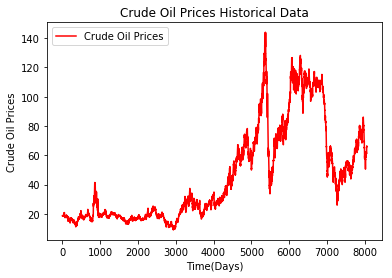

In [11]:
df_data_1_plot = df_data_1.iloc[:,1].values.astype(float)

# visualising the data
plt.plot(df_data_1_plot, color='red', label='Crude Oil Prices')
plt.title('Crude Oil Prices Historical Data')
plt.xlabel('Time(Days)')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()

In [12]:
from keras.preprocessing import sequence

### Stateful vs. Stateless LSTM
Stateless: LSTM updates parameters on batch 1 and then initiates cell states (meaning - memory, usually with zeros) for batch 2
Stateful: it uses batch 1 last output cell sates as initial states for batch 2.
When to use which?¶
When sequences in batches are related to each other (e.g. prices of one commodity), we should better use stateful mode
Else, when one sequence represents a complete sentence, we should go with stateless mode
### Batch-size: which batch-size to choose?
Very important decision!

Imagine, you must learn to recognize a bird... You are presented images of different birds.

What would you prefer:

To see the one image at a time, make your notes about special bird quilities (set your weights) and then see another bird and so on
OR may be you would better learn if you see - let's say 5 - bird images at ones. May be then you can faster notice the bird's intrinsic properties?
I'd say - the second method is more efficient for humans. We need more examples of an entitiy, that we have to distinguish.

So the machines! Therefore we select a batch size of 64. Batch size impacts the prediction accuracy.

In [13]:
# defining batch size and number of epochs
batch_size= 64
epochs=120
timesteps=10

### Batch-Size and training set size

In [14]:
length= len(df_data_1)
print(length)
length *= 1-0.1
print(length)

8059
7253.1


In [15]:
7253.0/64.0

113.328125

In [16]:
113*64

7232

In [17]:
7232.0%64.0

0.0

In [18]:
def get_train_length (dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length= len(dataset)
    length *= 1-test_percent
    train_length_values= []
    for x in range(int(length)-100, int(length)):
        modulo= x%batch_size
        if (modulo ==0):
            train_length_values.append(x)
            print(x)
    return max(train_length_values)

In [19]:
length=get_train_length(df_data_1, batch_size, 0.1)

7168
7232


In [20]:
# Adding timesteps *2 
upper_train= length + timesteps*2
df_data_1_train=df_data_1[0:upper_train]
training_set= df_data_1_train.iloc[:, 1:2].values
training_set.shape

(7252, 1)

In [21]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler(feature_range=(0,1))
training_set_scaled= sc.fit_transform(np.float64(training_set))
training_set_scaled.shape

(7252, 1)

In [22]:
X_train=[]
y_train=[]

# creating a data structure with n timesteps
print (length+timesteps)
for i in range(timesteps, length+timesteps): # timesteps=10
    X_train.append(training_set_scaled[i-timesteps:i,0])
    y_train.append(training_set_scaled[i:i+timesteps,0])
print (len(X_train))
print (len(y_train))

7242
7232
7232


In [23]:
# Reshaping to 3D since LSTM accept 3D samples. 3th dimension is 1 since we are predicting one variable
X_train, y_train = np.array(X_train), np.array(y_train) # change list to np array
X_train=np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train=np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)

(7232, 10, 1)
(7232, 10, 1)


In [24]:
# Import Keras Libraries
from keras.layers import Dense
from keras.layers import Input, LSTM
from keras.models import Model
import h5py


In [25]:
# initializing the LSTM Model with MAE Loss-Function
# Using functional API (instead of Sequential one)

input_1_mae=Input(batch_shape=(batch_size, timesteps, 1)) # 1 dim, we are prediction one variable, number of variables
lstm_1_mae= LSTM(10, stateful=True, return_sequences=True) (input_1_mae) # 1 means number of nodes(memory cell), it might be more
lstm_2_mae= LSTM(10, stateful=True, return_sequences=True) (lstm_1_mae)

output_1_mae= Dense(units=1) (lstm_2_mae) # units=1 bc we are predicting one dep. variable

regressor_mae= Model(inputs= input_1_mae, outputs=output_1_mae) # model takes 2 layers; input layer and output layer

regressor_mae.compile(optimizer='adam', loss='mae')
regressor_mae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (64, 10, 1)               0         
_________________________________________________________________
lstm_1 (LSTM)                (64, 10, 10)              480       
_________________________________________________________________
lstm_2 (LSTM)                (64, 10, 10)              840       
_________________________________________________________________
dense_1 (Dense)              (64, 10, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [26]:
# this import due to the limited resources in the free tier and the heavy resource consumption of Keras.
#This is a workaround to limit resource consumption

from keras import backend as K
K.set_session(K.tf.Session(config=K.tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)))

http://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [27]:
# 1st LSTM Layer
parameters = 4 * 10 * (1 + 10 + 1)
print(parameters)

480


In [28]:
parameters = 4 * 10 * (10 + 10 + 1)
print(parameters)

840


In [29]:
#Statefull
for i in range(epochs):
    print("Epoch: " + str(i))
    #run through all data but the cell, hidden state are used for the next batch.
    regressor_mae.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size)
    #resets only the states but the weights, cell and hidden are kept.
    regressor_mae.reset_states()
    
#Stateless
#between the batches the cell and hidden states are lost.
#regressor_mae.fit(X_train, y_train, shuffle=False, epochs = epochs, batch_size = batch_size)

Epoch: 0
Epoch 1/1
7232/7232 [==============================] - 2s 258us/step - loss: 0.0720
Epoch: 1
Epoch 1/1
7232/7232 [==============================] - 2s 213us/step - loss: 0.0869
Epoch: 2
Epoch 1/1
7232/7232 [==============================] - 2s 211us/step - loss: 0.0740
Epoch: 3
Epoch 1/1
7232/7232 [==============================] - 2s 209us/step - loss: 0.0653
Epoch: 4
Epoch 1/1
7232/7232 [==============================] - 2s 209us/step - loss: 0.0591
Epoch: 5
Epoch 1/1
7232/7232 [==============================] - 2s 211us/step - loss: 0.0547
Epoch: 6
Epoch 1/1
7232/7232 [==============================] - 2s 220us/step - loss: 0.0510
Epoch: 7
Epoch 1/1
7232/7232 [==============================] - 2s 210us/step - loss: 0.0478
Epoch: 8
Epoch 1/1
7232/7232 [==============================] - 2s 208us/step - loss: 0.0456
Epoch: 9
Epoch 1/1
7232/7232 [==============================] - 2s 209us/step - loss: 0.0441
Epoch: 10
Epoch 1/1
7232/7232 [==============================] - 2s 21

In [49]:
# save the model
import h5py
regressor_mae.save(filepath='my_model_with_mae_30_ts.h5')

In [50]:
# load model
from keras.models import load_model

regressor_mae=load_model(filepath='my_model_with_mae_30_ts.h5')

In [51]:
def get_test_length(dataset, batch_size):
    
    test_length_values = []
    for x in range(len(dataset) - 200, len(dataset) - timesteps*2): 
        modulo=(x-upper_train)%batch_size
        if (modulo == 0):
            test_length_values.append(x)
            print(x)
    return (max(test_length_values))

In [52]:
test_length = get_test_length(df_data_1, batch_size)
print(test_length)
upper_test = test_length + timesteps*2
testset_length = test_length - upper_train
print(testset_length)

7892
7956
8020
8020
768


In [53]:
print(upper_train, upper_test, len(df_data_1))

7252 8040 8059


In [55]:
# construct test set

#subsetting
df_data_1_test = df_data_1[upper_train:upper_test] 
test_set = df_data_1_test.iloc[:,1:2].values

#scaling
scaled_real_bcg_values_test = sc.fit_transform(np.float64(test_set))

#creating input data
X_test = []
for i in range(timesteps, testset_length + timesteps):
    X_test.append(scaled_real_bcg_values_test[i-timesteps:i, 0])
X_test = np.array(X_test)


#reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(768, 10, 1)


In [60]:
# predition
predicted_bcg_values_test_mae= regressor_mae.predict(X_test, batch_size= batch_size)
regressor_mae.reset_states()

print(predicted_bcg_values_test_mae.shape)

#reshaping
predicted_bcg_values_test_mae= np.reshape(predicted_bcg_values_test_mae,
                                         (predicted_bcg_values_test_mae.shape[0],
                                         predicted_bcg_values_test_mae.shape[1]))
print(predicted_bcg_values_test_mae.shape)

# inverse transform
predicted_bcg_values_test_mae= sc.inverse_transform(predicted_bcg_values_test_mae)

# creating y_test data
y_test=[]
for j in range(0, testset_length-timesteps):
    y_test= np.append(y_test, predicted_bcg_values_test_mae[j, timesteps-1]) # timesteps-1 equals to 9 columns in predicted . values and appends to y_test
    
# reshaping
y_test= np.reshape(y_test, (y_test.shape[0], 1))

print(y_test.shape)


(768, 10, 1)
(768, 10)
(758, 1)


In [72]:
Visualising the results

40.801048

In [75]:
# MSE
import math
from sklearn.metrics import mean_squared_error
rmse= math.sqrt(mean_squared_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test)-timesteps]))

print(rmse)

2.435996416666942
